In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

#### Importing data

In [9]:
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

In [10]:

#returns with dididend payments yearly and monthly
Y_ret = pd.read_excel(filepath + 'DS_RI_USD_Y.xlsx')
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')

#market value yearly and monthly
Y_mval = pd.read_excel(filepath + 'DS_MV_USD_Y.xlsx')
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')

#revenue yearly
revenue = pd.read_excel(filepath + 'DS_REV_USD_Y.xlsx')

#risk free rate
rfr = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')

#Escores
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')

#Companies and Regions
companies = pd.read_excel(filepath + 'Static.xlsx')


#### Only consider Pacific companies

In [11]:
# Merge data with companies on ISIN and keep only records where Region = PAC
#   [companies['Region'].isin(['PAC'])] is used to filter the rows where Region = PAC

Y_ret = Y_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_ret = M_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_mval = Y_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_mval = M_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
revenue = revenue.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
escore = escore.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')

# Drop the duplicated columns from the merge
for df in [M_ret, Y_ret, M_mval, Y_mval, revenue, escore]:
    df.drop(columns=['Region'], inplace=True)


#### Melting dataframes to have them in long format

In [12]:
M_ret_w = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
Y_ret_w = Y_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
M_mval_w = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
Y_mval_w = Y_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
revenue_w = revenue.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="REVENUE")
escore_w = escore.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="ESCORE")

#### Making sure the data is correct

In [13]:
for df in [M_ret_w, M_mval_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)
    #date format d.m.y
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

for df in [Y_ret_w, Y_mval_w, revenue_w, escore_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)

#### Compute Annualized returns 

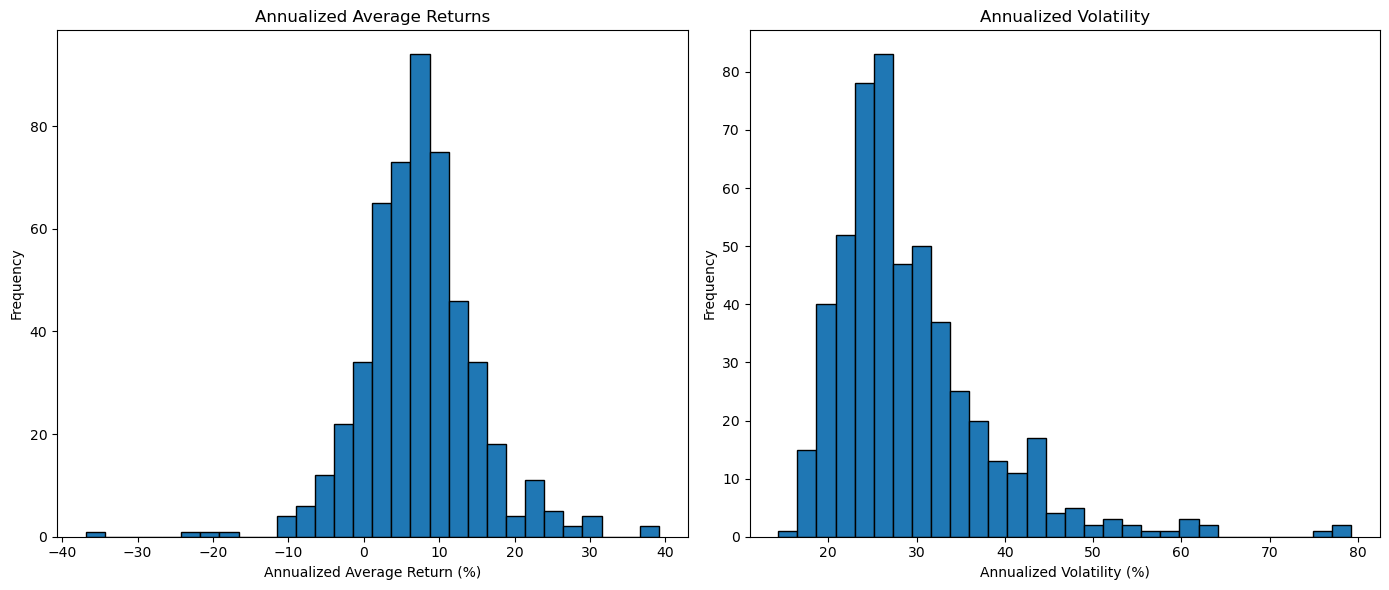

Correlation between annualized average returns and volatilities: 0.07


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data from 2014 to 2024
dfe1 = M_ret_w[(M_ret_w['DATE'] >= '2014-01-01') & (M_ret_w['DATE'] <= '2024-12-31')]

# Compute monthly returns in percentage
dfe1['RET_PCT'] = dfe1.groupby('ISIN')['RETURN'].pct_change() * 100

# Drop the first row (January 2014) of each ISIN
dfe1 = dfe1.dropna(subset=['RET_PCT'])

# Compute annualized average return and annualized volatility
annualized_returns = dfe1.groupby('ISIN')['RET_PCT'].mean() * 12
annualized_volatility = dfe1.groupby('ISIN')['RET_PCT'].std() * np.sqrt(12)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(annualized_returns, bins=30, edgecolor='k')
plt.title('Annualized Average Returns')
plt.xlabel('Annualized Average Return (%)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(annualized_volatility, bins=30, edgecolor='k')
plt.title('Annualized Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute correlation between individual average returns and volatilities
correlation = annualized_returns.corr(annualized_volatility)
print(f'Correlation between annualized average returns and volatilities: {correlation:.2f}')

# Comment on the results
# - Analyze the shape and spread of the histograms.
# - Discuss any notable features or outliers.
# - Interpret the correlation coefficient and its implications.